# Model Building

In this notebook, I will develop a predictive model to forecast future energy consumption. 

I will experiment with multiple regression algorithms, compare their performances using standard evaluation metrics (RMSE, MAE, R² Score), and select the best-performing model for deployment. This step is critical to ensure accurate and reliable energy demand forecasting.

### Key Steps:
- Load processed dataset
- Perform time-based train-test split
- Train multiple regression models
- Evaluate using RMSE, MAE, and R²
- Select and save the best model

In [11]:
## importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

import warnings
warnings.filterwarnings('ignore')

In [12]:
## loading the dataset
df_final = pd.read_parquet(r"C:\Users\himan\Desktop\Projects\Energy_Forecasting_System\data\processed-data\est_hourly_cleaned_with_features.parquet")
df_final.head()

,PJME_MW,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_holiday,PJME_PJMW_avg_Consumption
Datetime,,,,,,,,,,,,
2002-04-01 01:00:00,21734.0,4374.0,1,0,2,4,2002,91,1,14,0,13054.0
2002-04-01 02:00:00,20971.0,4306.0,2,0,2,4,2002,91,1,14,0,12638.5
2002-04-01 03:00:00,20721.0,4322.0,3,0,2,4,2002,91,1,14,0,12521.5
2002-04-01 04:00:00,20771.0,4359.0,4,0,2,4,2002,91,1,14,0,12565.0
2002-04-01 05:00:00,21334.0,4436.0,5,0,2,4,2002,91,1,14,0,12885.0


Now its time to split the data into "train" for training the model and "test" for testing it on the model. But unlike other cases where we split the data randomly, in time-series tasks, we need to take care that we only want to train our model on past data and test on the future data. This can prevent data leakage.  

In [13]:
df_final.drop(["PJME_PJMW_avg_Consumption"], axis=1, inplace=True)

In [15]:
## splitting the data into train and test
test_size = 0.8
split_range = int(test_size * len(df_final))  ## 0.8 * x can give us float value which will give us an error in train-test split. So we make sure that it returns only int.

In [16]:
## importing metrices
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
## creating function to evalueate model
import numpy as np
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [20]:
## our models
models = {
    "XGBoost": XGBRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
}

In [21]:
data_dict = {
    'PJME': {
        'X': df_final.drop(["PJME_MW"], axis=1),
        'y': df_final["PJME_MW"]
    },
    'PJMW': {
        'X': df_final.drop(["PJMW_MW"], axis=1),
        'y': df_final["PJMW_MW"]
    }
}

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Initialize result storage as a list (to collect each model's performance)
results = []

# Define the test size split
test_size = 0.8
split_range = int(test_size * len(df_final))

# Iterate through the data dictionary (PJME, PJMW)
for target_name, data in data_dict.items():
    X = data['X']
    y = data['y']

    # Train-test split
    X_train, X_test = X.iloc[:split_range], X.iloc[split_range:]
    y_train, y_test = y.iloc[:split_range], y.iloc[split_range:]

    result_target = []

    # Iterate through the models
    for model_name, model in models.items():
        # For other models (XGBoost, Random Forest, etc.)
        model.fit(X_train, y_train)

        # Predict on the training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluating the model
        train_metrices = evaluate_model(y_train, y_train_pred)
        test_metrices = evaluate_model(y_test, y_test_pred)

        # Store results for other models
        result_target.append({
            'Model': model_name,
            'Train_RMSE': train_metrices[2],
            'Test_RMSE': test_metrices[2],
            'Train_R2': train_metrices[3],
            'Test_R2': test_metrices[3],
            'Target': target_name
        })
    
    # Append target results to the overall results list
    results.extend(result_target)

# Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the final results DataFrame
results_df

,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Target
0,XGBoost,1010.479570,1815.091392,0.975558,0.922046,PJME
1,Decision Tree,2.422571,2272.203245,1.000000,0.877838,PJME
2,XGBoost,155.527193,289.999553,0.974545,0.914982,PJMW
3,Decision Tree,0.124083,361.074204,1.000000,0.868201,PJMW


We can see that XG Boost is performing best giving us approximately 92% of accuracy for both PJM Eastern region and PJM Western region.                  

Now i am going to Hyperparameter tune the XG Boost model to see if we can improve our model.

#### Hyperparameter Tuning 

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

## defining the params grid
param_grid = {
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

## initializing the model
rf_model = XGBRegressor()

## initializing the grid search
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  
                           cv=3, 
                           verbose=1, 
                           n_jobs=-1)

## fitting the grid search model
grid_search.fit(X_train, y_train)  

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
## Finding the best parameters
best_params = grid_search.best_params_
best_params

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 500,
 'subsample': 1.0}

In [28]:
## Retraining the model with best parameters manually
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

## predictions on the test set
predictions_rf = model.predict(X_test)

In [29]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_rf))
mae = mean_absolute_error(y_test, predictions_rf)
r2 = r2_score(y_test, predictions_rf)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 269.1604752410933
MAE: 210.41269779967783
R2 Score: 0.926761198774284


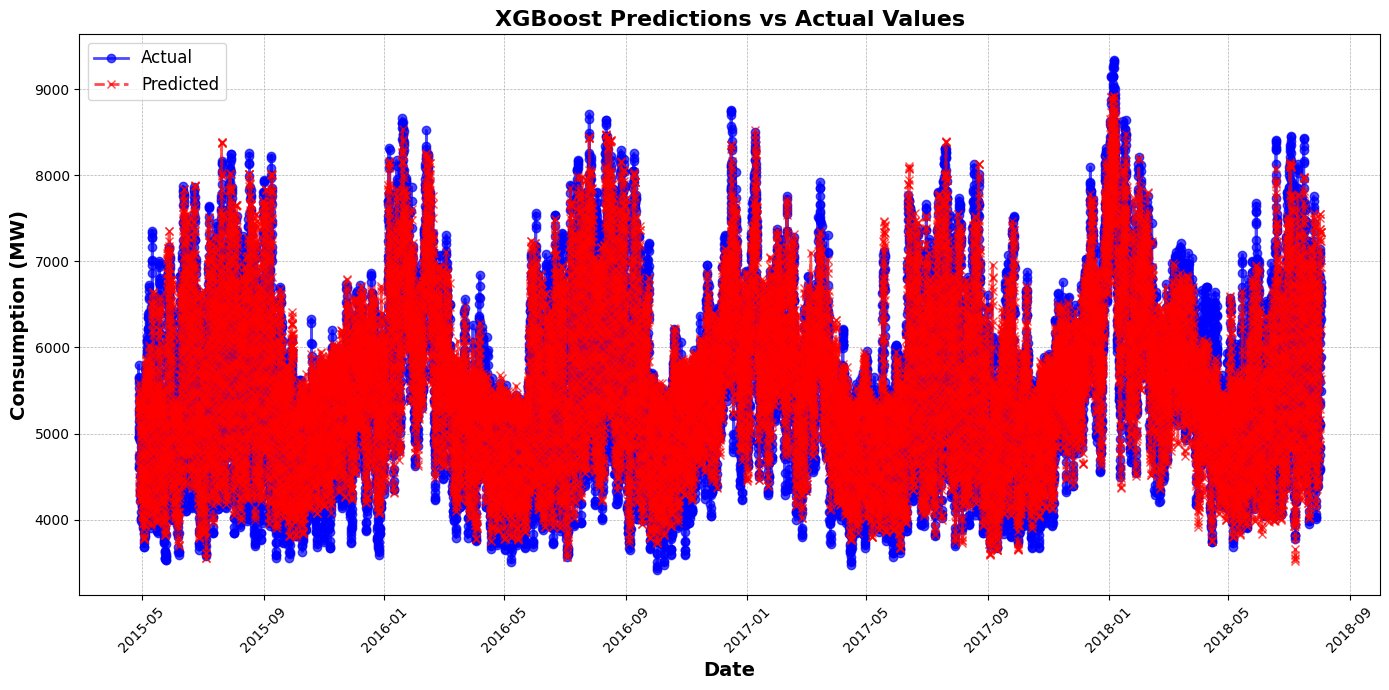

In [33]:
plt.figure(figsize=(14, 7))
# Plotting the actual values
plt.plot(y_test.index, y_test, label='Actual', color='blue', linewidth=2, marker='o', markersize=6, alpha=0.7, linestyle='-')

# Plotting the predicted values
plt.plot(y_test.index, predictions_rf, label='Predicted', color='red', linewidth=2, marker='x', markersize=6, alpha=0.7, linestyle='--')

plt.title('XGBoost Predictions vs Actual Values', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Consumption (MW)', fontsize=14, fontweight='bold')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout() 
plt.show()

      Feature  Importance
0     PJME_MW    0.536992
1        hour    0.078872
2   dayofweek    0.047425
3     quarter    0.162525
4       month    0.019235
5        year    0.035447
6   dayofyear    0.056626
7  dayofmonth    0.004700
8  weekofyear    0.057487
9  is_holiday    0.000691


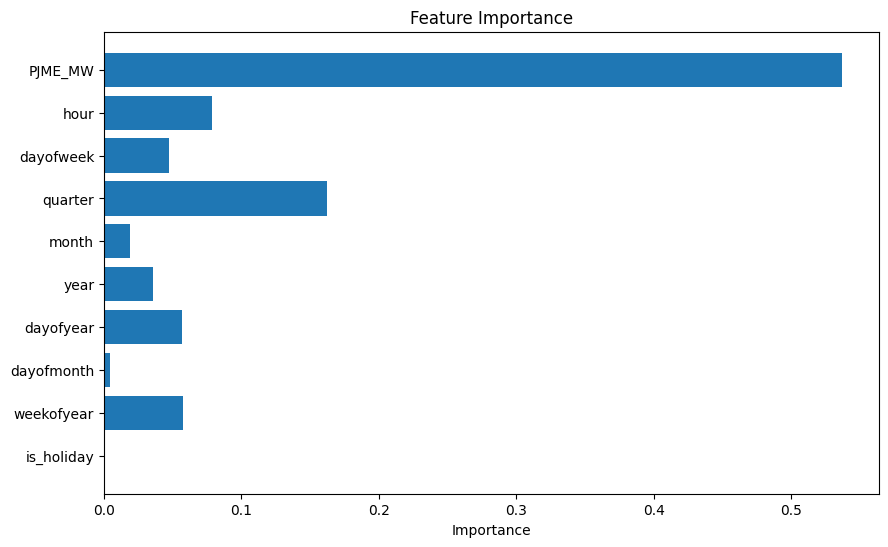

In [34]:
## Feature Importance
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

In [35]:
## saving the model
import joblib

model_path = r'C:\Users\himan\Desktop\Projects\Energy_Forecasting_System\outputs\xgb_model.pkl'
joblib.dump(model, model_path)

['C:\\Users\\himan\\Desktop\\Projects\\Energy_Forecasting_System\\outputs\\xgb_model.pkl']